**Phase 1: Setup and Data Preprocessing**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
df.drop('customerID',axis=1,inplace=True)

In [13]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [14]:
df['TotalCharges']=pd.to_numeric(df["TotalCharges"],errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median())

,TotalCharges
0,29.85
1,1889.50
2,108.15
3,1840.75
4,151.65
...,...
7038,1990.50
7039,7362.90
7040,346.45
7041,306.60


In [15]:
df['Churn'].map({'Yes':1,'No':0})

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [16]:
df=pd.get_dummies(df,drop_first=True)

In [17]:
df.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_Yes'],
      dtype='object')

## Phase 2: Train Neural Network Model (MLP Classifier)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

In [34]:
X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

In [23]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [26]:
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.89      0.87      1036
        True       0.64      0.53      0.58       373

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


 Phase 3: Integrate Symbolic Rules (Symbolic Layer)

In [27]:
def symbolic_rules(row):
    rules = []
    if row['Contract_Two year'] == 0 and row['tenure'] < 12:
        rules.append('Likely to churn: Short contract and low tenure')

    if row['InternetService_Fiber optic'] == 1 and row['StreamingMovies_Yes'] == 1:
        rules.append('Streaming user on fiber optic - high usage')

    if row['MonthlyCharges'] > 80:
        rules.append('High monthly charges - churn risk')

    return rules

In [28]:
X_test_df = pd.DataFrame(X_test_df, columns=df.drop('Churn_Yes', axis=1).columns)
sample = X_test_df.iloc[:5]
sample_scaled = scaler.transform(sample)
sample_preds = model.predict(sample_scaled)

for i, row in sample.iterrows():
    print(f"\nPrediction: {'Churn' if sample_preds[i] == 1 else 'No Churn'}")
    print("Symbolic Explanation:", symbolic_rules(row))
    print("-" * 40)


Prediction: Churn
Symbolic Explanation: ['Likely to churn: Short contract and low tenure']
----------------------------------------

Prediction: No Churn
Symbolic Explanation: []
----------------------------------------

Prediction: No Churn
Symbolic Explanation: []
----------------------------------------

Prediction: Churn
Symbolic Explanation: ['Likely to churn: Short contract and low tenure']
----------------------------------------

Prediction: No Churn
Symbolic Explanation: []
----------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# **Phase 4: Neuro-Symbolic Fusion**

In [30]:
def neuro_symbolic_decision(row, model, scaler):
    row_scaled = scaler.transform([row])
    pred = model.predict(row_scaled)[0]
    rules = symbolic_rules(row)

    return {
        'prediction': 'Churn' if pred == 1 else 'No Churn',
        'explanation': rules
    }

# Example usage
sample_result = neuro_symbolic_decision(X_test_df.iloc[1], model, scaler)
print(sample_result)

{'prediction': 'No Churn', 'explanation': []}




# Visualization




In [31]:
!pip install matplotlib seaborn

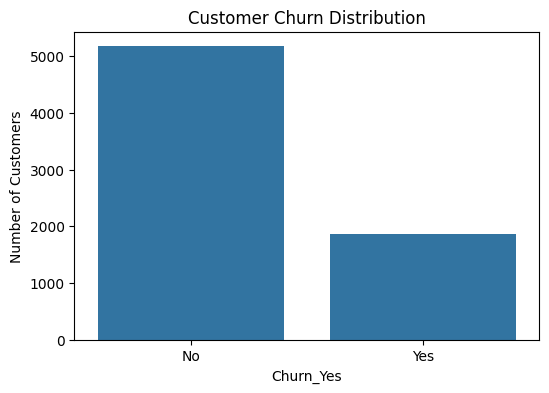

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn_Yes', data=df)
plt.title('Customer Churn Distribution')
plt.xlabel('Churn_Yes')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


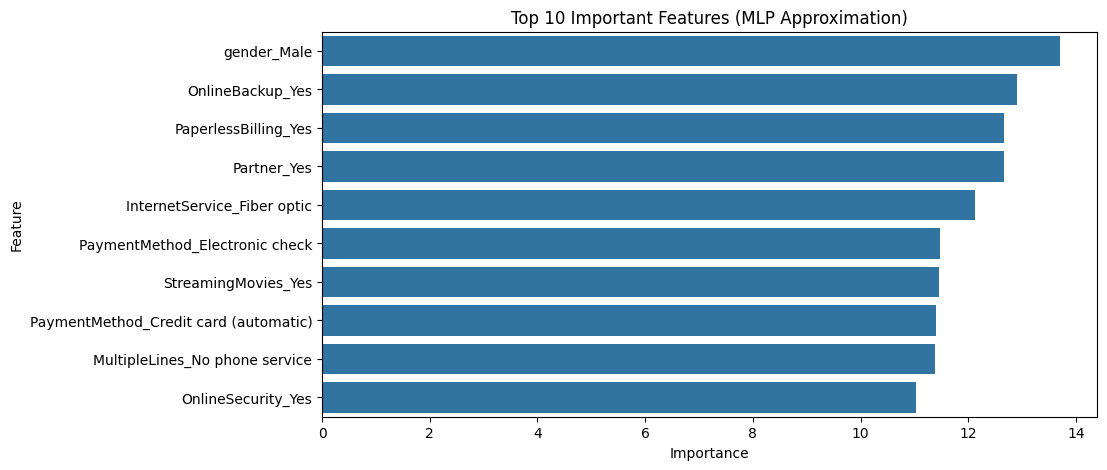

In [33]:
feature_importance = np.abs(model.coefs_[0]).sum(axis=1)
feature_names = df.drop('Churn_Yes', axis=1).columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Important Features (MLP Approximation)')
plt.show()